In [1]:
#import libraries
import csv
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import statistics
import glob
import requests
from itertools import repeat

In [2]:
#actual COVID-19 cases data for PA
url2 = 'https://raw.githubusercontent.com/IvanVoinovGitHub/Covid19-Analysis-Modeling/main/Data/COVID-19_Aggregate_Cases_Current_Daily_County_Health.csv'
df1 = pd.read_csv(url2)

In [3]:
url = 'https://github.com/reichlab/covid19-forecast-hub/tree/master/data-processed/TTU-squider'
download = requests.get(url).content

csvStringList = []
hrefStringList = []
urlExtension = []
rawUrls = []
tempList = []
urlExtensionwoutblob = []
urlBeginning = 'https://raw.githubusercontent.com'

urlStringList = str(requests.get(url).text).split(" ")
for i in urlStringList:
  if "csv" in i:
    csvStringList.append(i)

for i in csvStringList:
  if "href" in i and "/reichlab/covid19-forecast-hub/blob/master/data-processed/" in i:
    hrefStringList.append(i)

for i in hrefStringList:
  tempList1 = i.split("\"")
  for x in tempList1:
    if "/reichlab/covid19-forecast-hub/blob/master/data-processed/" in x:
      urlExtension.append(x)

for i in urlExtension:
  newString = ""
  tempList = []
  temp = i.split("/")
  for x in temp:
    if "blob" not in x:
      tempList.append(x)
  for j in range(1, len(tempList)):
    newString += "/" + tempList[j]
  urlExtensionwoutblob.append(newString)


for i in urlExtensionwoutblob:
  finalUrl = urlBeginning + i
  rawUrls.append(finalUrl)

In [4]:
#reading all the raw data, filtering PA cases data, and ensemble back into one dataframe
all_data = []
for url in rawUrls:
    df3=pd.read_csv(url)
    df2_case = df3[df3['target'].str.contains('case')]
    df2_casesPA = df2_case[(df2_case["type"]=="point") & (df2_case["location"]=="42")]
    all_data.append(df2_casesPA)

In [5]:
len(all_data)

80

In [6]:
df2 = pd.concat(all_data)
df2.head(5)

,forecast_date,target,target_end_date,location,type,quantile,value
91,2020-08-17,1 wk ahead inc case,2020-08-22,42,point,NaN,5148.824
250,2020-08-17,2 wk ahead inc case,2020-08-29,42,point,NaN,4863.299
409,2020-08-17,3 wk ahead inc case,2020-09-05,42,point,NaN,4544.705
568,2020-08-17,4 wk ahead inc case,2020-09-12,42,point,NaN,4206.468
91,2020-08-23,1 wk ahead inc case,2020-08-29,42,point,NaN,5202.729


In [7]:
#convert date to datetime object
df1['Date'] = pd.to_datetime(df1['Date'])
df2['forecast_date'] = pd.to_datetime(df2['forecast_date'])
df2['target_end_date'] = pd.to_datetime(df2['target_end_date'])

In [8]:
#sort datasets by date
df1.sort_values(by='Date')
df2.sort_values(by='target_end_date')

,forecast_date,target,target_end_date,location,type,quantile,value
91,2020-08-17,1 wk ahead inc case,2020-08-22,42,point,NaN,5148.824
250,2020-08-17,2 wk ahead inc case,2020-08-29,42,point,NaN,4863.299
91,2020-08-23,1 wk ahead inc case,2020-08-29,42,point,NaN,5202.729
409,2020-08-17,3 wk ahead inc case,2020-09-05,42,point,NaN,4544.705
250,2020-08-23,2 wk ahead inc case,2020-09-05,42,point,NaN,4858.131
...,...,...,...,...,...,...,...
250,2022-03-13,2 wk ahead inc case,2022-03-26,42,point,NaN,10716.857
568,2022-02-27,4 wk ahead inc case,2022-03-26,42,point,NaN,18208.668
568,2022-03-06,4 wk ahead inc case,2022-04-02,42,point,NaN,12051.876
409,2022-03-13,3 wk ahead inc case,2022-04-02,42,point,NaN,7844.311


In [9]:
#filterinng out data for PA (FIPS code = 42)
df2_2 = df2[df2['target'].str.contains('1')]
df2_2.shape

(80, 7)

In [10]:
#finding weekly increase in cases in PA
df_weekly=df2_2.groupby('target_end_date').agg('last').reset_index()
df_weekly.rename(
    columns={"target_end_date":"Date"},inplace=True)
#df_weekly

In [11]:
#creating a column for daily additions
df_weekly["dayRate"] = df_weekly["value"] / 7
mask = (df_weekly['Date'] <= '2022-03-02')
df_weekly = df_weekly.loc[mask]
df_weekly.head(5)

,Date,forecast_date,target,location,type,quantile,value,dayRate
0,2020-08-22,2020-08-17,1 wk ahead inc case,42,point,NaN,5148.824,735.546286
1,2020-08-29,2020-08-23,1 wk ahead inc case,42,point,NaN,5202.729,743.247000
2,2020-09-19,2020-09-13,1 wk ahead inc case,42,point,NaN,12147.381,1735.340143
3,2020-10-03,2020-09-27,1 wk ahead inc case,42,point,NaN,14134.019,2019.145571
4,2020-10-10,2020-10-04,1 wk ahead inc case,42,point,NaN,6614.980,944.997143


In [12]:
df_weekly.tail(5)

,Date,forecast_date,target,location,type,quantile,value,dayRate
72,2022-01-29,2022-01-23,1 wk ahead inc case,42,point,NaN,19132.687,2733.241000
73,2022-02-05,2022-01-30,1 wk ahead inc case,42,point,NaN,29183.890,4169.127143
74,2022-02-12,2022-02-06,1 wk ahead inc case,42,point,NaN,128344.117,18334.873857
75,2022-02-19,2022-02-13,1 wk ahead inc case,42,point,NaN,75902.689,10843.241286
76,2022-02-26,2022-02-20,1 wk ahead inc case,42,point,NaN,59548.651,8506.950143


In [17]:
# creating a list of predictions from the model data
predictions = []
for i in df_weekly["dayRate"]:
    predictions.extend(repeat(i,7))
#del predictions[-2:]
#preds = pd.DataFrame(predictions)
#preds.drop(preds.tail(2).index,inplace=True) 
print(predictions)

[735.5462857142857, 735.5462857142857, 735.5462857142857, 735.5462857142857, 735.5462857142857, 735.5462857142857, 735.5462857142857, 743.2470000000001, 743.2470000000001, 743.2470000000001, 743.2470000000001, 743.2470000000001, 743.2470000000001, 743.2470000000001, 1735.3401428571428, 1735.3401428571428, 1735.3401428571428, 1735.3401428571428, 1735.3401428571428, 1735.3401428571428, 1735.3401428571428, 2019.1455714285714, 2019.1455714285714, 2019.1455714285714, 2019.1455714285714, 2019.1455714285714, 2019.1455714285714, 2019.1455714285714, 944.9971428571428, 944.9971428571428, 944.9971428571428, 944.9971428571428, 944.9971428571428, 944.9971428571428, 944.9971428571428, 949.9685714285714, 949.9685714285714, 949.9685714285714, 949.9685714285714, 949.9685714285714, 949.9685714285714, 949.9685714285714, 951.4907142857144, 951.4907142857144, 951.4907142857144, 951.4907142857144, 951.4907142857144, 951.4907142857144, 951.4907142857144, 923.17, 923.17, 923.17, 923.17, 923.17, 923.17, 923.17

In [18]:
len(predictions)

539

In [22]:
#select all the dates to be merged with prediction list
mask = (df1['Date'] >= '2020-08-22') & (df1['Date'] <= '2022-02-11')
df1_copy = df1.loc[mask]
df1_copy = df1_copy.groupby(["Date"]).sum().reset_index()
df1_copy.head(5)

,Date,New Cases,7-day Average New Cases,Cumulative cases,Population (2019),New Case Rate,7-Day Average New Case Rate,Cumulative Case Rate,County FIPS Code,Longitude,Latitude
0,2020-08-22,1200,1319.3,266722,25603978,275.1,294.3,41842.6,2860489,-5275.682283,2774.207671
1,2020-08-23,848,1314.9,267570,25603978,167.7,292.8,42010.5,2860489,-5275.682283,2774.207671
2,2020-08-24,1188,1297.7,268758,25603978,275.7,286.9,42287.0,2860489,-5275.682283,2774.207671
3,2020-08-25,1016,1268.5,269774,25603978,245.2,283.4,42531.8,2860489,-5275.682283,2774.207671
4,2020-08-26,1278,1229.8,271052,25603978,296.6,274.4,42829.0,2860489,-5275.682283,2774.207671


In [23]:
len(df1_copy)

539

In [24]:
# assigning predictions list to the actual dataframe
df1_copy['Prediction'] = predictions

In [25]:
df1_copy.head(20)

,Date,New Cases,7-day Average New Cases,Cumulative cases,Population (2019),New Case Rate,7-Day Average New Case Rate,Cumulative Case Rate,County FIPS Code,Longitude,Latitude,Prediction
0,2020-08-22,1200,1319.3,266722,25603978,275.1,294.3,41842.6,2860489,-5275.682283,2774.207671,735.546286
1,2020-08-23,848,1314.9,267570,25603978,167.7,292.8,42010.5,2860489,-5275.682283,2774.207671,735.546286
2,2020-08-24,1188,1297.7,268758,25603978,275.7,286.9,42287.0,2860489,-5275.682283,2774.207671,735.546286
3,2020-08-25,1016,1268.5,269774,25603978,245.2,283.4,42531.8,2860489,-5275.682283,2774.207671,735.546286
4,2020-08-26,1278,1229.8,271052,25603978,296.6,274.4,42829.0,2860489,-5275.682283,2774.207671,735.546286
5,2020-08-27,1702,1261.4,272754,25603978,405.1,284.9,43233.7,2860489,-5275.682283,2774.207671,735.546286
6,2020-08-28,1664,1271.1,274418,25603978,368.6,290.5,43602.3,2860489,-5275.682283,2774.207671,735.546286
7,2020-08-29,1380,1296.2,275798,25603978,288.6,292.6,43890.6,2860489,-5275.682283,2774.207671,743.247000
8,2020-08-30,1052,1325.3,276850,25603978,206.1,297.6,44095.9,2860489,-5275.682283,2774.207671,743.247000
9,2020-08-31,1664,1393.5,278514,25603978,290.0,299.6,44386.7,2860489,-5275.682283,2774.207671,743.247000


In [26]:
# renaming the dataframe for graphing
merged_df_new = df1_copy

In [27]:
merged_df_new.shape

(539, 12)

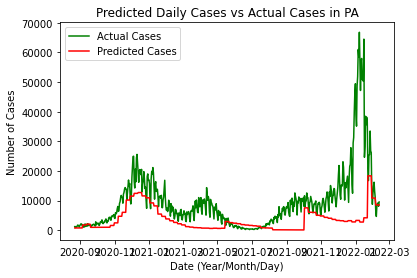

In [28]:
#Create plot of Actual vs. Predicted Cases

#Actual Cases Line
plt.plot(merged_df_new['Date'], merged_df_new['New Cases'], color='g', label='Actual Cases')

#Predicted Cases Line
plt.plot(merged_df_new['Date'], merged_df_new['Prediction'], color='r', label='Predicted Cases')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Number of Cases') 
plt.title("Predicted Daily Cases vs Actual Cases in PA")

#Display Plot
plt.legend()
plt.show()

In [29]:
#error calculations
#confirmed = merged_df_new['Actual']
#projected = merged_df_new['Prediction']
error = []
rawerror = []

for index, row in merged_df_new.iterrows():
  rawerror.append(-1*(row['New Cases'] - row["Prediction"]) / row['New Cases'])
  error.append((abs(row['New Cases'] - row["Prediction"])) / row['New Cases'])

underpredictCount = 0
overpredictCount = 0
for x in rawerror:
  if x < 0:
    underpredictCount += 1
  elif x > 0:
    overpredictCount += 1

underpredictPerecentage = underpredictCount / len(rawerror)
overpredictPercentage = 1 - underpredictPerecentage

print(underpredictCount)
print(underpredictPerecentage)
print(overpredictCount)
print(overpredictPercentage)
print(len(error))

print(error)
print(rawerror)

452
0.8385899814471243
87
0.16141001855287573
539
[0.38704476190476195, 0.13261051212938013, 0.3808532948532949, 0.27603712035995503, 0.42445517549742906, 0.56783414470371, 0.5579649725274726, 0.4614152173913043, 0.2934914448669201, 0.5533371394230768, 0.588000554323725, 0.6571738929889298, 0.5938540983606557, 0.6156944157187176, 0.3246871319520174, 0.4509532967032967, 0.7743764241893076, 0.1305911107930146, 0.4558222674976031, 0.15266594587053572, 0.09523454491285567, 0.5484245179666959, 0.45892021056977705, 0.07463539347911484, 0.3197029878618114, 0.06833099017384732, 0.24178694429801442, 0.10942064364207221, 0.3041258152745635, 0.17683175709308122, 0.4480156875834446, 0.40190054249547924, 0.48863790970933835, 0.5326423625830154, 0.4880838879430429, 0.4780392464678179, 0.2952755404832556, 0.662413442989136, 0.46207895162595053, 0.5415209597352454, 0.5851665626949469, 0.6051668447927799, 0.5140496862687873, 0.39702743074416075, 0.5080192790663317, 0.6522329260651629, 0.632060822008617

In [30]:
#accuracy calculations
accuracy = []

for i in error:
  accuracy.append(1 - i)

print(accuracy)

[0.6129552380952381, 0.8673894878706199, 0.6191467051467051, 0.723962879640045, 0.5755448245025709, 0.43216585529629004, 0.44203502747252743, 0.5385847826086957, 0.7065085551330799, 0.44666286057692317, 0.411999445676275, 0.3428261070110702, 0.4061459016393443, 0.38430558428128236, 0.6753128680479825, 0.5490467032967032, 0.22562357581069237, 0.8694088892069853, 0.5441777325023969, 0.8473340541294643, 0.9047654550871443, 0.4515754820333041, 0.541079789430223, 0.9253646065208851, 0.6802970121381886, 0.9316690098261526, 0.7582130557019856, 0.8905793563579278, 0.6958741847254365, 0.8231682429069188, 0.5519843124165553, 0.5980994575045208, 0.5113620902906617, 0.46735763741698455, 0.5119161120569571, 0.5219607535321821, 0.7047244595167443, 0.33758655701086404, 0.5379210483740495, 0.4584790402647546, 0.41483343730505307, 0.39483315520722007, 0.48595031373121267, 0.6029725692558392, 0.4919807209336683, 0.3477670739348371, 0.3679391779913822, 0.33409084069020867, 0.27341687192118236, 0.39418018

In [ ]:
#Create Error and Accuracy Column and insert list data
merged_df_new['Error'] = error
merged_df_new['Accuracy'] = accuracy
merged_df_new['RawError'] = rawerror

print(merged_df_new)

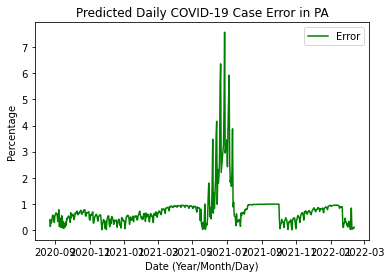

In [32]:
from IPython.core.pylabtools import figsize
#Create plot of Error

#Error Line
plt.plot(merged_df_new['Date'], merged_df_new['Error'], color='g', label='Error')


#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("Predicted Daily COVID-19 Case Error in PA")
#Display Plot
plt.legend()

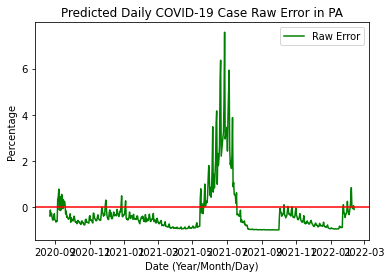

In [33]:
#Create plot of Raw Error

#Raw Error Line
plt.plot(merged_df_new['Date'], merged_df_new['RawError'], color='g', label='Raw Error')
plt.axhline(y=0.0, color='r', linestyle='-')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("Predicted Daily COVID-19 Case Raw Error in PA")
#Display Plot
plt.legend()
plt.show()

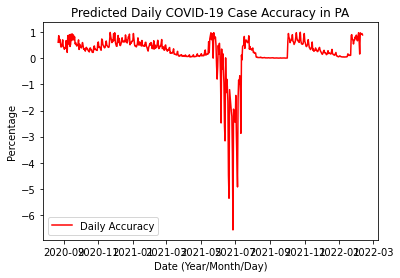

In [34]:
#Create plot of Accuracy

#Accuracy Line
plt.plot(merged_df_new['Date'], merged_df_new['Accuracy'], color='r', label='Daily Accuracy')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [35]:
#Calculate Weekly Accuracy Averages
weeklyAccuracy = 0
averageWeeklyAccuracy = []
length = len(accuracy) #   =245
amountOfWeeks = int(length / 7) #   =35
remainderDays = length % 7 #  

i = 0
while i < length:
  weeklyAccuracy += accuracy[i]
  if (i + 1) % 7 == 0 and amountOfWeeks > 0:
    averageWeeklyAccuracy.append(weeklyAccuracy / 7)
    amountOfWeeks -= 1
    weeklyAccuracy = 0
  if remainderDays > 0:
    if (i + 1) % remainderDays == 0 and amountOfWeeks == 0:
      averageWeeklyAccuracy.append(weeklyAccuracy / remainderDays)
      weeklyAccuracy = 0
  i += 1

weeklyDateList = []
i = 0
weeklyDateList.append(merged_df_new['Date'][i])
while i < length:
  if (i + 1) % 7 == 0:
    weeklyDateList.append(merged_df_new['Date'][i])
  i += 1

In [36]:
len(weeklyDateList)

78

In [37]:
#del averageWeeklyAccuracy[-1:]
#len(averageWeeklyAccuracy)

In [38]:
#Create Dataframe for Weekly Accuracy
i = 0
data = []
while i < len(averageWeeklyAccuracy):
  data.append([weeklyDateList[i], averageWeeklyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Week Of', 'Average Weekly Accuracy'])

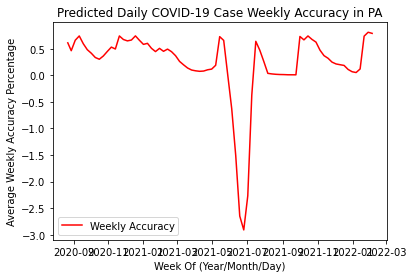

In [39]:
#Create plot of Weekly Accuracy

#Accuracy Line
plt.plot(df['Week Of'], df['Average Weekly Accuracy'], color='r', label='Weekly Accuracy')

#Create XY Labels and Title
plt.xlabel('Week Of (Year/Month/Day)') 
plt.ylabel('Average Weekly Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Weekly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [40]:
#Create Running Weekly Average
runningweeklyAccuracy = 0
runningAverageWeeklyAccuracy = []
length = len(accuracy)

i = 1
j = 8
#Add first week average
runningAverageWeeklyAccuracy.append(averageWeeklyAccuracy[0])

while j < length:
  temp_i = i
  temp_j = j
  while temp_i < temp_j:
    runningweeklyAccuracy += accuracy[temp_i]
    temp_i += 1
  runningAverageWeeklyAccuracy.append(runningweeklyAccuracy / 7)
  runningweeklyAccuracy = 0

  i += 1
  j += 1

In [41]:
#Create Dataframe for Running Weekly Accuracy
i = 0
data = []
while i < len(runningAverageWeeklyAccuracy):
  data.append([merged_df_new['Date'][i], runningAverageWeeklyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Date', 'Running Weekly Average Accuracy'])

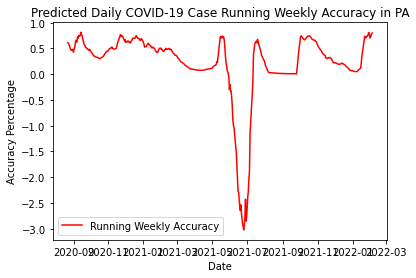

In [42]:
#Create plot of Running Weekly Accuracy

#Accuracy Line
plt.plot(df['Date'], df['Running Weekly Average Accuracy'], color='r', label='Running Weekly Accuracy')

#Create XY Labels and Title
plt.xlabel('Date') 
plt.ylabel('Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Running Weekly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

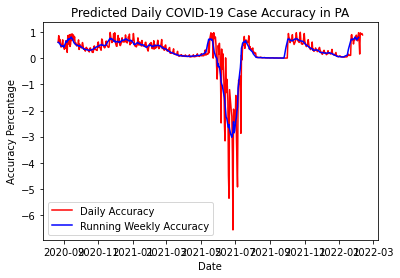

In [43]:
#Plot with combined daily accuracy and running weekly accuracy

#Daily Accuracy
plt.plot(merged_df_new['Date'], merged_df_new['Accuracy'], color='r', label='Daily Accuracy')

#Running Accuracy Line
plt.plot(df['Date'], df['Running Weekly Average Accuracy'], color='b', label='Running Weekly Accuracy')

#Create XY Labels and Title
plt.xlabel('Date') 
plt.ylabel('Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [ ]:
#merged_df_new.to_csv('DDS_everyday_predictions.csv')

In [44]:
#Calculate Monthly Accuracy Averages
#We are going to use an average of 30 days per month for these calculations

monthlyAccuracy = 0
averageMonthlyAccuracy = []
amountOfMonths = int(length / 30)
remainderDays = length % 30

i = 0
while i < length:
  monthlyAccuracy += accuracy[i]
  if (i + 1) % 30 == 0 and amountOfMonths > 0:
    averageMonthlyAccuracy.append(monthlyAccuracy / 30)
    amountOfMonths -= 1
    monthlyAccuracy = 0
  if (i + 1) % remainderDays == 0 and remainderDays > 0 and amountOfMonths == 0:
    averageMonthlyAccuracy.append(monthlyAccuracy / remainderDays)
    monthlyAccuracy = 0
  i += 1

weeklyDateListForMonths = []
i = 0
weeklyDateListForMonths.append(merged_df_new['Date'][i])
while i < length:
  if (i + 1) % 30 == 0:
    weeklyDateListForMonths.append(merged_df_new['Date'][i])
  i += 1


In [45]:
#del averageMonthlyAccuracy[-1:]
len(averageMonthlyAccuracy)

18

In [46]:
#Create Dataframe for Monthly Accuracy
i = 0
data = []
while i < len(averageMonthlyAccuracy):
  data.append([weeklyDateListForMonths[i], averageMonthlyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Month Of', 'Average Monthly Accuracy'])

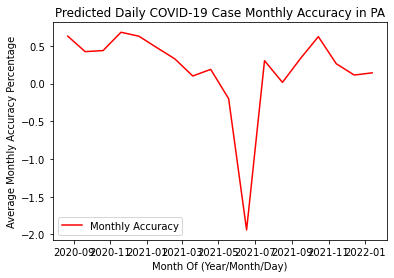

In [47]:
#Create plot of Monthly Accuracy

#Accuracy Line
plt.plot(df['Month Of'], df['Average Monthly Accuracy'], color='r', label='Monthly Accuracy')

#Create XY Labels and Title
plt.xlabel('Month Of (Year/Month/Day)') 
plt.ylabel('Average Monthly Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Monthly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [48]:
#Calculate Running Monthly Accuracy

runningmonthlyAccuracy = 0
runningAveragemonthlyAccuracy = []
length = len(accuracy)

i = 1
j = 31
#Add first week average
runningAveragemonthlyAccuracy.append(averageMonthlyAccuracy[0])

while j < length:
  temp_i = i
  temp_j = j
  while temp_i < temp_j:
    runningmonthlyAccuracy += accuracy[temp_i]
    temp_i += 1
  runningAveragemonthlyAccuracy.append(runningmonthlyAccuracy / 30)
  runningmonthlyAccuracy = 0

  i += 1
  j += 1

In [49]:
#Create Dataframe for Running Monthly Accuracy
i = 0
data = []
while i < len(runningAveragemonthlyAccuracy):
  data.append([merged_df_new['Date'][i], runningAveragemonthlyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Date', 'Running Monthly Average Accuracy'])

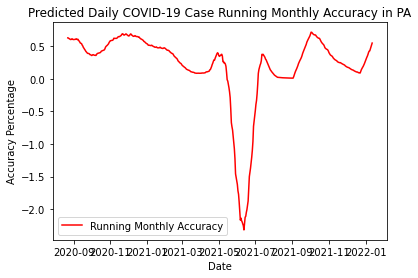

In [50]:
#Create plot of Running Monthly Accuracy

#Accuracy Line
plt.plot(df['Date'], df['Running Monthly Average Accuracy'], color='r', label='Running Monthly Accuracy')

#Create XY Labels and Title
plt.xlabel('Date') 
plt.ylabel('Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Running Monthly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [51]:
#Calculate Yearly Accuracy Averages
#We are going to use an average of 365 days per year for these calculations

yearlyAccuracy = 0
averageYearlyAccuracy = []
amountOfYears = int(length / 365)
remainderDays = length % 365

i = 0
while i < length:
  yearlyAccuracy += accuracy[i]
  if (i + 1) % 365 == 0 and amountOfYears > 0:
    averageYearlyAccuracy.append(yearlyAccuracy / 365)
    amountOfYears -= 1
    yearlyAccuracy = 0
  if (i + 1) % remainderDays == 0 and remainderDays > 0 and amountOfYears == 0:
    averageYearlyAccuracy.append(yearlyAccuracy / remainderDays)
    yearlyAccuracy = 0
  i += 1

weeklyDateListForYears = []
i = 0
weeklyDateListForYears.append(merged_df_new['Date'][i])
while i < length:
  if (i + 1) % 365 == 0:
    weeklyDateListForYears.append(merged_df_new['Date'][i])
  i += 1

In [52]:
print(averageYearlyAccuracy)

[0.1683664346372662, 0.2542438508077864]


In [53]:
#Create Dataframe for Yearly Accuracy
i = 0
data = []
while i < len(averageYearlyAccuracy):
  data.append([weeklyDateListForYears[i], averageYearlyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Year Of', 'Average Yearly Accuracy'])

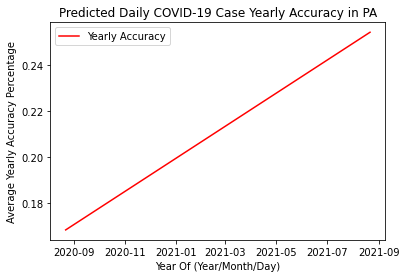

In [54]:
#Create plot of Yearly Accuracy

#Accuracy Line
plt.plot(df['Year Of'], df['Average Yearly Accuracy'], color='r', label='Yearly Accuracy')

#Create XY Labels and Title
plt.xlabel('Year Of (Year/Month/Day)') 
plt.ylabel('Average Yearly Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Yearly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [55]:
#Calculate Running Yearly Accuracy

runningyearlyAccuracy = 0
runningAverageyearlyAccuracy = []
length = len(accuracy)

i = 1
j = 366
#Add first week average
runningAverageyearlyAccuracy.append(averageYearlyAccuracy[0])

while j < length:
  temp_i = i
  temp_j = j
  while temp_i < temp_j:
    runningyearlyAccuracy += accuracy[temp_i]
    temp_i += 1
  runningAverageyearlyAccuracy.append(runningyearlyAccuracy / 365)
  runningyearlyAccuracy = 0

  i += 1
  j += 1

In [56]:
#Create Dataframe for Running Yearly Accuracy
i = 0
data = []
while i < len(runningAverageyearlyAccuracy):
  data.append([merged_df_new['Date'][i], runningAverageyearlyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Date', 'Running Yearly Average Accuracy'])

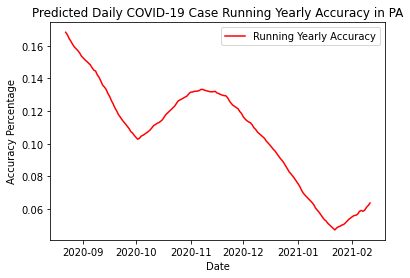

In [57]:
#Create plot of Running Yearly Accuracy

#Accuracy Line
plt.plot(df['Date'], df['Running Yearly Average Accuracy'], color='r', label='Running Yearly Accuracy')

#Create XY Labels and Title
plt.xlabel('Date') 
plt.ylabel('Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Running Yearly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [58]:
#Calculate Overall Accuracy
overallAccuracy = merged_df_new['Accuracy'].mean()
print(overallAccuracy)

0.2204279821423693


In [59]:
#Create new dataframe for year 2022
data_2022 = merged_df_new[(merged_df_new['Date'] > '2022-01-01')]

In [60]:
#create error and accuracy lists for 2022
error_2022=[]
for index, row in data_2022.iterrows():
  error_2022.append((abs(row['New Cases'] - row["Prediction"])) / row['New Cases'])

accuracy_2022 = []
for i in error_2022:
  accuracy_2022.append(1 - i)

In [61]:
#check head of 2022 data
data_2022.head(5)

,Date,New Cases,7-day Average New Cases,Cumulative cases,Population (2019),New Case Rate,7-Day Average New Case Rate,Cumulative Case Rate,County FIPS Code,Longitude,Latitude,Prediction,Error,Accuracy,RawError
498,2022-01-02,35128,38695.9,4203914,25603978,6449.2,7426.4,1172327.7,2860489,-5275.682283,2774.207671,3288.765429,0.906378,0.093622,-0.906378
499,2022-01-03,48768,41456.9,4252682,25603978,9816.9,8055.2,1182144.5,2860489,-5275.682283,2774.207671,3288.765429,0.932563,0.067437,-0.932563
500,2022-01-04,51898,44396.0,4304580,25603978,10744.4,8691.2,1192888.2,2860489,-5275.682283,2774.207671,3288.765429,0.936630,0.063370,-0.936630
501,2022-01-05,61004,47411.2,4365584,25603978,11662.5,9215.5,1204551.4,2860489,-5275.682283,2774.207671,3288.765429,0.946089,0.053911,-0.946089
502,2022-01-06,58492,49136.1,4424076,25603978,12854.6,9728.8,1217406.1,2860489,-5275.682283,2774.207671,3288.765429,0.943774,0.056226,-0.943774


([<matplotlib.axis.XTick at 0x7fd03630b990>,
 <a list of 6 Text major ticklabel objects>)

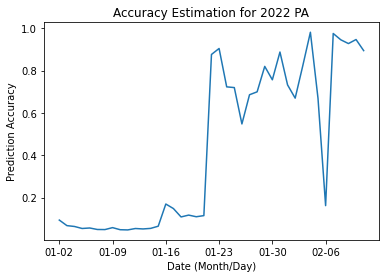

In [62]:
#create plot for 2022 accuracy
plt.xlabel('Date (Month/Day)') 
plt.ylabel('Prediction Accuracy') 
plt.title("Accuracy Estimation for 2022 PA")

plt.plot(data_2022['Date'].dt.strftime('%m-%d'), accuracy_2022, label='Accuracy 2022')
plt.xticks(np.arange(0, len(data_2022['Date']), 7))

In [63]:
#cleans accuracy list of all nan values
newlist = [x for x in accuracy if math.isnan(x) == False]
print(newlist)

[0.6129552380952381, 0.8673894878706199, 0.6191467051467051, 0.723962879640045, 0.5755448245025709, 0.43216585529629004, 0.44203502747252743, 0.5385847826086957, 0.7065085551330799, 0.44666286057692317, 0.411999445676275, 0.3428261070110702, 0.4061459016393443, 0.38430558428128236, 0.6753128680479825, 0.5490467032967032, 0.22562357581069237, 0.8694088892069853, 0.5441777325023969, 0.8473340541294643, 0.9047654550871443, 0.4515754820333041, 0.541079789430223, 0.9253646065208851, 0.6802970121381886, 0.9316690098261526, 0.7582130557019856, 0.8905793563579278, 0.6958741847254365, 0.8231682429069188, 0.5519843124165553, 0.5980994575045208, 0.5113620902906617, 0.46735763741698455, 0.5119161120569571, 0.5219607535321821, 0.7047244595167443, 0.33758655701086404, 0.5379210483740495, 0.4584790402647546, 0.41483343730505307, 0.39483315520722007, 0.48595031373121267, 0.6029725692558392, 0.4919807209336683, 0.3477670739348371, 0.3679391779913822, 0.33409084069020867, 0.27341687192118236, 0.39418018

In [64]:
#calculate variance and st deviation of accuracy
var = sum((l-overallAccuracy)**2 for l in newlist) / len(newlist)
st_dev = math.sqrt(var)
print(var)
print(st_dev)

0.6023766377313386
0.7761292661221703


In [65]:
#calculate median of accuracy
accMedian = statistics.median(newlist)
print(accMedian)

0.3456035996488147


In [66]:
#Seperate Running Weekly Average plot into 3 plots for the 3 variants: Original, Delta, Omicron

# Start Date - May 20th 2021
# Delta: May 20th 2021 - December 1st 2021
# Omicron: December 1st 2021 - Present

In [67]:
type(merged_df_new['Date'][1])

pandas._libs.tslibs.timestamps.Timestamp

In [68]:
merged_df_new.index[merged_df_new['Date']=='2021-05-20'].tolist()

[271]

In [69]:
merged_df_new.index[merged_df_new['Date']=='2021-12-01'].tolist()

[466]

In [70]:
#print(merged_inner)
standardVariantDF = merged_df_new[:271]
deltaVariantDF = merged_df_new[271:466]
omicronVariantDF = merged_df_new[466:]

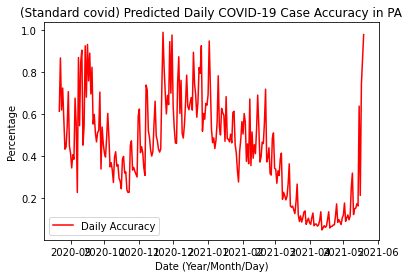

In [71]:
#Create plot of Accuracy

#Accuracy Line
plt.plot(standardVariantDF['Date'], standardVariantDF['Accuracy'], color='r', label='Daily Accuracy')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("(Standard covid) Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

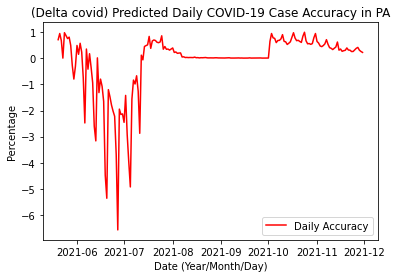

In [72]:
#Create plot of Accuracy

#Accuracy Line
plt.plot(deltaVariantDF['Date'], deltaVariantDF['Accuracy'], color='r', label='Daily Accuracy')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("(Delta covid) Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

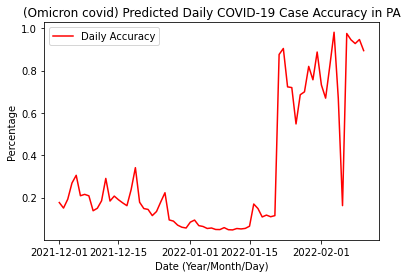

In [73]:
#Create plot of Accuracy

#Accuracy Line
plt.plot(omicronVariantDF['Date'], omicronVariantDF['Accuracy'], color='r', label='Daily Accuracy')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("(Omicron covid) Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()